In [2]:
pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 6.4 MB 16.4 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [10]:
import yfinance as yf
data_train = yf.download("BTC-USD", start="2014-01-01", end="2021-09-01")
data_test = yf.download("BTC-USD", start="2021-09-01")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


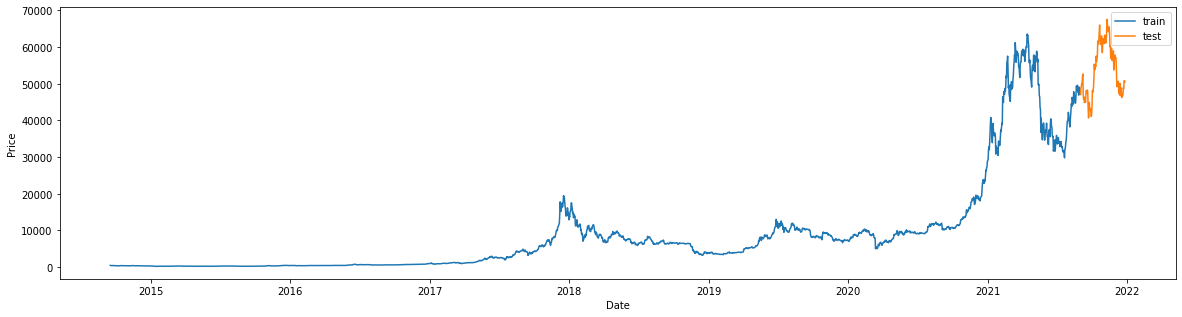

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))

plt.xlabel('Date')
plt.ylabel('Price')

plt.plot(data_train['Open'], label = "train")
plt.plot(data_test['Open'], label = "test")
plt.legend()


In [22]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

train = data_train['Open'].values.reshape(-1, 1)
test = data_test['Open'].values.reshape(-1, 1)

scaler = MinMaxScaler()

normalized_train = np.squeeze(scaler.fit_transform(train))
normalized_test = np.squeeze(scaler.fit_transform(test))

print(normalized_train)

[0.00456166 0.00441952 0.00390242 ... 0.76811948 0.73953855 0.74072935]


In [40]:
sequence_train_x = []
sequence_train_y = []

for i in range(len(normalized_train) - 60):
    sequence_train_x.append(normalized_train[i:i+60])
    sequence_train_y.append(normalized_train[i+60])

sequence_train_x = np.array(sequence_train_x).reshape(2482, 60, 1)
sequence_train_y = np.array(sequence_train_y)

print(np.array(sequence_train_x).shape)
print(np.array(sequence_train_y).shape)

(2482, 60, 1)
(2482,)


In [41]:
sequence_test_x = []
sequence_test_y = []

for i in range(len(normalized_test) - 60):
    sequence_test_x.append(normalized_test[i:i+60])
    sequence_test_y.append(normalized_test[i+60])

sequence_test_x = np.array(sequence_test_x).reshape(57, 60, 1)
sequence_test_y = np.array(sequence_test_y)

print(np.array(sequence_test_x).shape)
print(np.array(sequence_test_y).shape)

(57, 60, 1)
(57,)


In [42]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM

model = keras.models.Sequential()

model.add(LSTM(50, input_shape=(60, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(1))

loss = "mean_squared_error"
opt = "adam"
model.compile(loss=loss, optimizer=opt)
h = model.fit(sequence_train_x, sequence_train_y, epochs=100, batch_size=32)

Epoch 1/100
78/78 [==============================] - 15s 61ms/step - loss: 0.0052
Epoch 2/100
78/78 [==============================] - 5s 61ms/step - loss: 0.0016
Epoch 3/100
78/78 [==============================] - 5s 61ms/step - loss: 0.0012
Epoch 4/100
78/78 [==============================] - 5s 61ms/step - loss: 0.0014
Epoch 5/100
78/78 [==============================] - 5s 61ms/step - loss: 0.0012
Epoch 6/100
78/78 [==============================] - 5s 61ms/step - loss: 0.0011
Epoch 7/100
78/78 [==============================] - 5s 61ms/step - loss: 0.0010
Epoch 8/100
78/78 [==============================] - 5s 61ms/step - loss: 9.3706e-04
Epoch 9/100
78/78 [==============================] - 5s 62ms/step - loss: 9.4866e-04
Epoch 10/100
78/78 [==============================] - 5s 61ms/step - loss: 8.3600e-04
Epoch 11/100
78/78 [==============================] - 5s 61ms/step - loss: 7.7448e-04
Epoch 12/100
78/78 [==============================] - 5s 61ms/step - loss: 8.6580e-04
Epoc

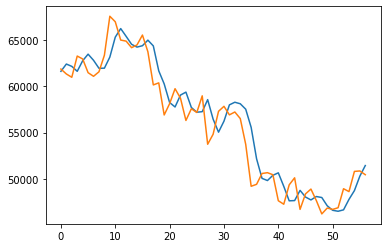

In [52]:
predict = model.predict(sequence_test_x)
real_predict = scaler.inverse_transform(predict)
real_label = scaler.inverse_transform([sequence_test_y])

plt.plot(real_predict)
plt.plot(np.squeeze(real_label))

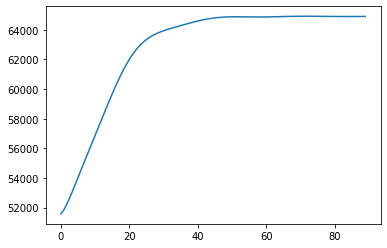

In [92]:
last_60_days = list(normalized_test[-60:])
predict = []

for i in range(90):
    pred = model.predict(np.expand_dims(last_60_days, 0))  
    predict.append(pred[0][0])
    last_60_days.append(pred[0][0])
    last_60_days.remove(last_60_days[0])

plt.plot(np.squeeze(scaler.inverse_transform(np.array(predict).reshape(-1, 1))))
